In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.sparse import csr_matrix
from numpy.linalg import norm
from sklearn.metrics import (
    precision_score, 
    accuracy_score, 
    f1_score, 
    confusion_matrix
)

# Cargar los datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv",sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv",sep=";")

train_data

,Label,Texto
0,0,rita maestre anuncia que en agosto llegarán 34...
1,0,psoe aclara que la mesa de negociación debe se...
2,0,campaña por la educación nueva propuesta legis...
3,1,educación y formación profesional destina más ...
4,1,la resurrección del presupuesto de andalucía y...
...,...,...
51988,0,nueva fórmula de alfonso guerra contra los par...
51989,0,el ministerio de sanidad lanza una campaña par...
51990,0,feijóo ensaya para las generales y moreno se s...
51991,0,el ministerio de educación anuncia nuevas medi...


In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix
from scipy.stats import zscore
from scipy.sparse import csr_matrix
from numpy.linalg import norm

##################################
# 1. Carga de datos
##################################
train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data   = val_data.dropna(subset=['Texto', 'Label'])
test_data  = test_data.dropna(subset=['Texto', 'Label'])

X_train = train_data['Texto']
y_train = train_data['Label'] 
X_val   = val_data['Texto']
y_val   = val_data['Label']
X_test  = test_data['Texto']
y_test  = test_data['Label']

##################################
# 2. Vectorización y Selección de features
##################################

# A) TF-IDF con n-grams
tfidf_vectorizer_ngrams = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    dtype=np.float32  # Si tu versión de sklearn lo soporta
)
X_train_vec = tfidf_vectorizer_ngrams.fit_transform(X_train)
X_val_vec   = tfidf_vectorizer_ngrams.transform(X_val)
X_test_vec  = tfidf_vectorizer_ngrams.transform(X_test)

# B) SelectKBest (chi2)
selector = SelectKBest(chi2, k=3000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_val_reduced   = selector.transform(X_val_vec)
X_test_reduced  = selector.transform(X_test_vec)

# Forzamos a float32 (por si devuelven float64)
X_train_reduced = X_train_reduced.astype(np.float32)
X_val_reduced   = X_val_reduced.astype(np.float32)
X_test_reduced  = X_test_reduced.astype(np.float32)

##################################
# 3. Normalización
##################################

scaler = StandardScaler(with_mean=False)
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_val_normalized   = scaler.transform(X_val_reduced)
X_test_normalized  = scaler.transform(X_test_reduced)

# Convertir también a float32 en la matriz dispersa
X_train_normalized = X_train_normalized.astype(np.float32)
X_val_normalized   = X_val_normalized.astype(np.float32)
X_test_normalized  = X_test_normalized.astype(np.float32)

##################################
# 4. Cálculo de norma fila a fila por lotes (para evitar MemoryError)
##################################

def compute_row_norms_sparse(sparse_matrix, batch_size=10000):
    n_rows = sparse_matrix.shape[0]
    row_norms_list = []
    for start in range(0, n_rows, batch_size):
        end = min(start + batch_size, n_rows)
        chunk = sparse_matrix[start:end]
        # sqrt( sum(x^2) ) en cada fila, sin convertir a denso
        chunk_norms = np.sqrt(chunk.power(2).sum(axis=1))
        # Convertir a 1D y float32
        chunk_norms = np.ravel(chunk_norms).astype(np.float32)
        row_norms_list.append(chunk_norms)
    return np.concatenate(row_norms_list, axis=0)

row_norms = compute_row_norms_sparse(X_train_normalized, batch_size=10000)
z_scores = zscore(row_norms)
mask = np.abs(z_scores) < 2.5

X_train_cleaned = X_train_normalized[mask]
y_train_cleaned = y_train[mask]

##################################
# 5. Clase LogisticRegressionGD (NumPy) con ponderación
##################################
class LogisticRegressionGD:
    def __init__(self,
                 learning_rate=0.01,
                 epochs=1000,
                 tolerance=1e-5,
                 decay_rate=0.0,
                 momentum=0.0,
                 pos_weight=1.1):

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tolerance = tolerance
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.pos_weight = pos_weight  # NUEVO: peso para la clase positiva

        self.velocity_weights = None  
        self.velocity_bias = 0       

        # Métricas por época
        self.losses_train = []
        self.losses_val = []
        self.accuracies_train = []
        self.accuracies_val = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, y_train, X_val, y_val):
        # Aseguramos float32
        X_train = X_train.astype(np.float32)
        X_val   = X_val.astype(np.float32)

        n_samples, n_features = X_train.shape
        # Iniciamos en float32
        self.weights = np.zeros(n_features, dtype=np.float32)
        self.bias = 0.0
        self.velocity_weights = np.zeros(n_features, dtype=np.float32)

        for epoch in range(self.epochs):
            # Predicciones en entrenamiento
            linear_model_train = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid(linear_model_train)

            loss_train = -np.mean(
                self.pos_weight * y_train * np.log(y_pred_train + 1e-9) +
                (1 - y_train) * np.log(1 - y_pred_train + 1e-9)
            )
            self.losses_train.append(loss_train)

            # Precisión en entrenamiento (umbral=0.5)
            y_pred_train_class = (y_pred_train > 0.5).astype(np.float32)
            accuracy_train = np.mean(y_pred_train_class == y_train)
            self.accuracies_train.append(accuracy_train)

            
            y_train_ponderada = self.pos_weight * y_train
            error = y_pred_train - y_train_ponderada
            dw = (1 / n_samples) * np.dot(X_train.T, error)
            db = (1 / n_samples) * np.sum(error)

            # Actualización con momentum
            self.velocity_weights = (
                self.momentum * self.velocity_weights
                - self.learning_rate * dw
            )
            self.velocity_bias = (
                self.momentum * self.velocity_bias
                - self.learning_rate * db
            )
            self.weights += self.velocity_weights
            self.bias   += self.velocity_bias

            # Decaída del learning rate
            self.learning_rate *= (1 / (1 + self.decay_rate * epoch))

            # ---- Validación ----
            linear_model_val = np.dot(X_val, self.weights) + self.bias
            y_pred_val = self.sigmoid(linear_model_val)

           
            loss_val = -np.mean(
                self.pos_weight * y_val * np.log(y_pred_val + 1e-9) +
                (1 - y_val) * np.log(1 - y_pred_val + 1e-9)
            )
            self.losses_val.append(loss_val)

            # Precisión en validación (umbral=0.5)
            y_pred_val_class = (y_pred_val > 0.5).astype(np.float32)
            accuracy_val = np.mean(y_pred_val_class == y_val)
            self.accuracies_val.append(accuracy_val)

            # Imprimir cada 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch:4d} | "
                      f"Loss_Train: {loss_train:.4f} | "
                      f"Loss_Val: {loss_val:.4f} | "
                      f"Acc_Train: {accuracy_train:.4f} | "
                      f"Acc_Val: {accuracy_val:.4f}")

            # Verificar convergencia
            if np.linalg.norm(dw) < self.tolerance and abs(db) < self.tolerance:
                print(f"Converged at epoch {epoch}")
                break

    def predict(self, X, threshold=0.5):
        X = X.astype(np.float32)
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > threshold).astype(int)

##################################
# 6. Entrenamiento
##################################

gd_model = LogisticRegressionGD(
    learning_rate=0.001, 
    epochs=5000, 
    tolerance=1e-5, 
    decay_rate=1e-12, 
    momentum=0.9,
    pos_weight=1.1
)

gd_model.fit(
    X_train_cleaned.toarray(),  # Entrenamiento
    y_train_cleaned.values,
    X_val_normalized.toarray(), # Validación
    y_val.values
)

##################################
# 7. Evaluación en Validación
##################################

y_val_pred = gd_model.predict(X_val_normalized.toarray(), threshold=0.6)

# Matriz de confusión
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
TN, FP, FN, TP = val_conf_matrix.ravel()

# Métricas
val_precision = precision_score(y_val, y_val_pred)
val_accuracy  = accuracy_score(y_val, y_val_pred)
val_f1        = f1_score(y_val, y_val_pred)
val_sensitivity = TP / (TP + FN)  # Recall
val_specificity = TN / (TN + FP)

print("\nValidation Metrics:")
print("Confusion Matrix:\n", val_conf_matrix)
print(f"Precision:   {val_precision:.3f}")
print(f"Accuracy:    {val_accuracy:.3f}")
print(f"F1-Score:    {val_f1:.3f}")
print(f"Sensitivity: {val_sensitivity:.3f}")
print(f"Specificity: {val_specificity:.3f}")

##################################
# 8. Evaluación en Test
##################################

y_test_pred = gd_model.predict(X_test_normalized.toarray(), threshold=0.6)

# Matriz de confusión
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
TN, FP, FN, TP = test_conf_matrix.ravel()

# Métricas
test_precision = precision_score(y_test, y_test_pred)
test_accuracy  = accuracy_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)
test_sensitivity = TP / (TP + FN)  # Recall
test_specificity = TN / (TN + FP)

print("\nTest Metrics:")
print("Confusion Matrix:\n", test_conf_matrix)
print(f"Precision:   {test_precision:.4f}")
print(f"Accuracy:    {test_accuracy:.4f}")
print(f"F1-Score:    {test_f1:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")


Epoch    0 | Loss_Train: 0.7277 | Loss_Val: 0.7282 | Acc_Train: 0.5010 | Acc_Val: 0.6447
Epoch   10 | Loss_Train: 0.7045 | Loss_Val: 0.7030 | Acc_Train: 0.6508 | Acc_Val: 0.6534
Epoch   20 | Loss_Train: 0.6682 | Loss_Val: 0.6687 | Acc_Train: 0.6699 | Acc_Val: 0.6699
Epoch   30 | Loss_Train: 0.6357 | Loss_Val: 0.6392 | Acc_Train: 0.6922 | Acc_Val: 0.6860
Epoch   40 | Loss_Train: 0.6091 | Loss_Val: 0.6157 | Acc_Train: 0.7149 | Acc_Val: 0.7046
Epoch   50 | Loss_Train: 0.5878 | Loss_Val: 0.5972 | Acc_Train: 0.7320 | Acc_Val: 0.7217
Epoch   60 | Loss_Train: 0.5708 | Loss_Val: 0.5827 | Acc_Train: 0.7447 | Acc_Val: 0.7341
Epoch   70 | Loss_Train: 0.5570 | Loss_Val: 0.5711 | Acc_Train: 0.7527 | Acc_Val: 0.7402
Epoch   80 | Loss_Train: 0.5458 | Loss_Val: 0.5617 | Acc_Train: 0.7588 | Acc_Val: 0.7436
Epoch   90 | Loss_Train: 0.5364 | Loss_Val: 0.5540 | Acc_Train: 0.7629 | Acc_Val: 0.7478
Epoch  100 | Loss_Train: 0.5284 | Loss_Val: 0.5475 | Acc_Train: 0.7663 | Acc_Val: 0.7513
Epoch  110 | Loss_Tra

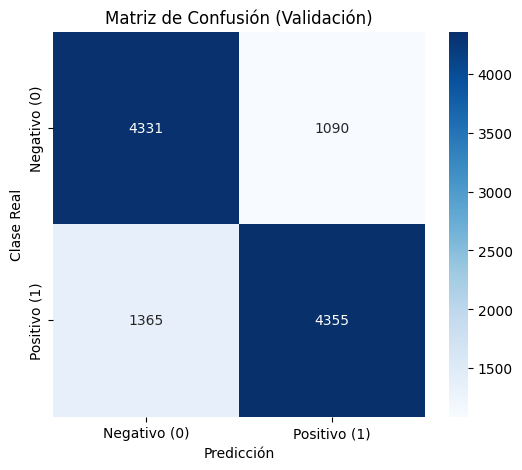

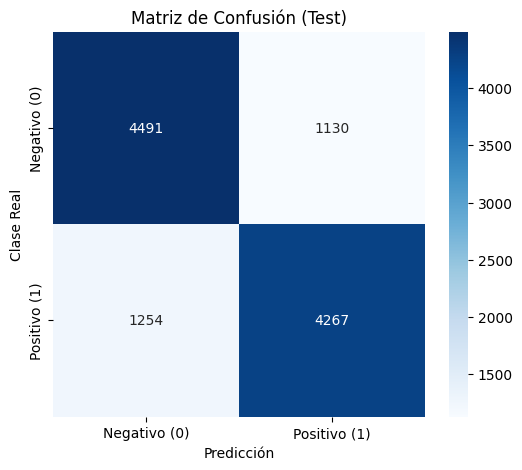

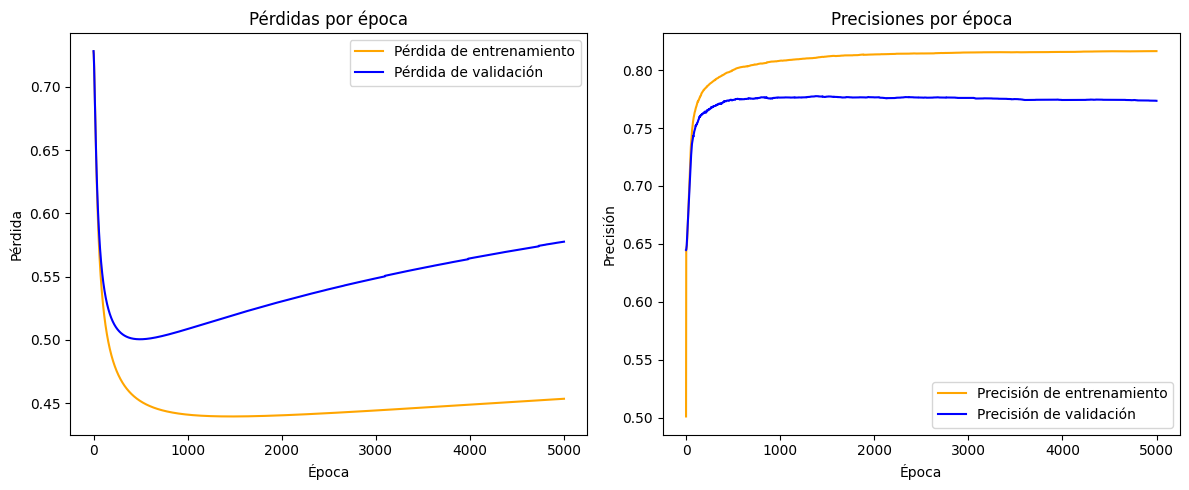

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Asumiendo que ya tienes y_test, y_test_pred
cm_test = confusion_matrix(y_test, y_test_pred)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Asumiendo que ya tienes y_val, y_val_pred, y_test, y_test_pred
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Graficar la matriz de confusión (Validación)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Negativo (0)", "Positivo (1)"],
            yticklabels=["Negativo (0)", "Positivo (1)"])
plt.title("Matriz de Confusión (Validación)")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.show()

# Graficar la matriz de confusión (Test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Negativo (0)", "Positivo (1)"],
            yticklabels=["Negativo (0)", "Positivo (1)"])
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.show()



# Graficar pérdidas y precisiones por épocas
plt.figure(figsize=(12, 5))

# Pérdidas por época
plt.subplot(1, 2, 1)
plt.plot(gd_model.losses_train, label="Pérdida de entrenamiento", color="orange")
plt.plot(gd_model.losses_val, label="Pérdida de validación", color="blue")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdidas por época")
plt.legend()

# Precisión por época
plt.subplot(1, 2, 2)
plt.plot(gd_model.accuracies_train, label="Precisión de entrenamiento", color="orange")
plt.plot(gd_model.accuracies_val, label="Precisión de validación", color="blue")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisiones por época")
plt.legend()

plt.tight_layout()
plt.show()

